In [2]:
### uses vgg.json file to create binary images of the ground truth fretboard segmentations

import cv2 as cv
import json
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image

# expects fretboard dataset to be in data folder on same level as tabs_generator folder
train_str = "test" # change to train or test to perform on respective data
dataset_path = "../data/fretboard_dataset/"
images_path = f"../data/fretboard_dataset/fretboard_frames_{train_str}/"
image_fns = os.listdir(images_path)
json_fn = os.path.join(dataset_path, f"fretboard_labels_{train_str}_vgg.json")
f = open(json_fn)
data = json.load(f) # data is dict of json contents
k = list(data.keys())

for i, fn in enumerate(image_fns):
    img_path = os.path.join(images_path, fn)
    out_path = os.path.join(images_path, "annotated_"+fn)
    img = np.asarray(Image.open(img_path)) # loads images w/ range of 0:255
    x_list = data[k[i]]["regions"]["0"]["shape_attributes"]["all_points_x"] # list of rectangle coordinates
    y_list = data[k[i]]["regions"]["0"]["shape_attributes"]["all_points_y"]
    x_list.pop(-1) # remove duplicate of first coordinate from end of lists
    y_list.pop(-1)
    poly_corners = np.asarray([list(zip(x_list, y_list))], dtype=np.int32) # repackage into np array w/ correct dtype
    new_img = np.zeros((img.shape[0], img.shape[1]), np.uint8) # create empty binary image mask
    new_img = cv.fillPoly(new_img, poly_corners, 255) # fill polygon of rectangle coordinates
    Image.fromarray(new_img).save(out_path) # save output image

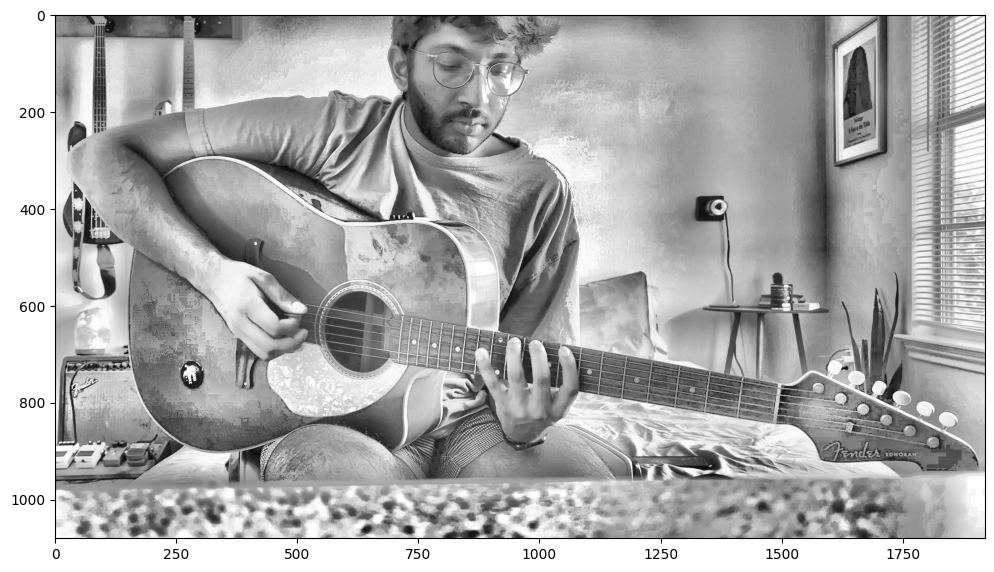

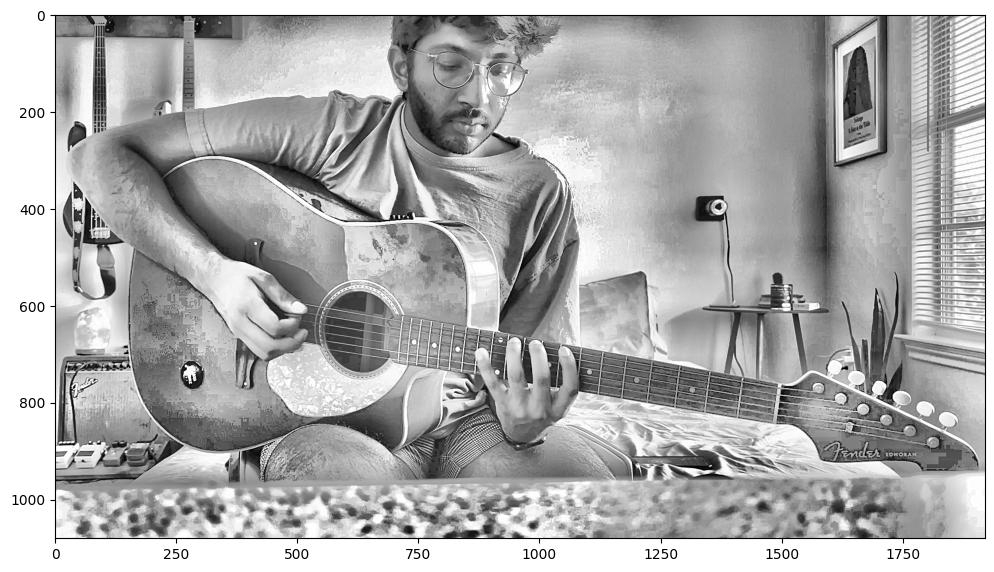

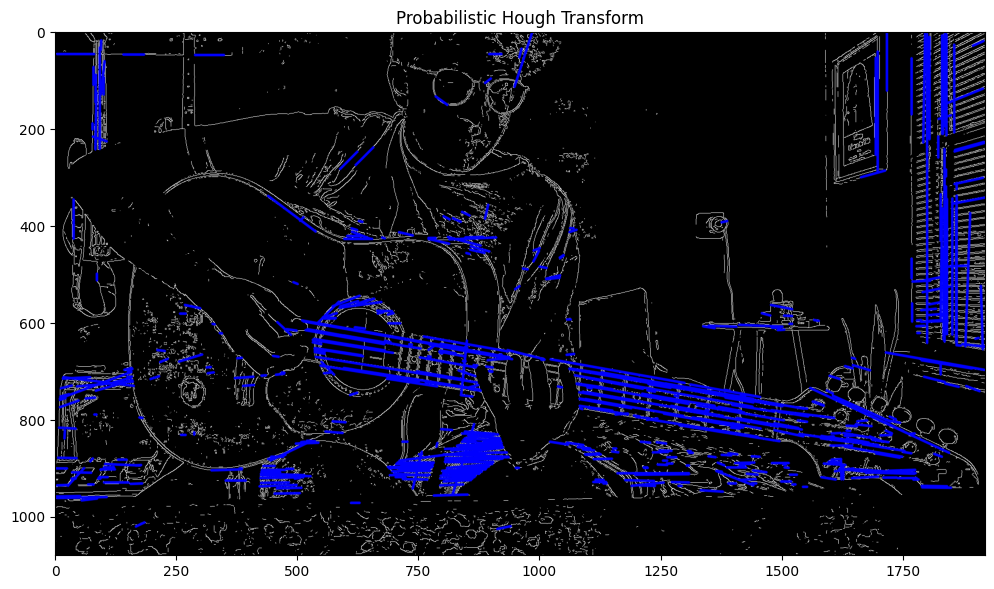

In [42]:
# generate hough lines of image
%matplotlib inline
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from scipy.ndimage import median_filter

train_flag = True
dataset_path = "../data/fretboard_dataset/"
garrett_path = "../data/new_dataset/garrett_amogus/"
if train_flag:
    frames_path = "../data/fretboard_dataset/fretboard_frames_train/"
    out = "../data/fretboard_dataset/train.json"
else:
    frames_path = "../data/fretboard_dataset/fretboard_frames_test/"
    out = "../data/fretboard_dataset/test.json"

data = {}
frames_fn_list = os.listdir(frames_path)
train_fns = []
for f in frames_fn_list:
    if "annotated" not in f:
        train_fns.append(f)

num = 500 # top number of lines to keep
normalize = np.array([1920, 1080])
normalize = np.tile(normalize, num*2)

for frame_fn in train_fns[50:51]:
    img = cv.imread(os.path.join(frames_path, frame_fn))

    lab= cv.cvtColor(img, cv.COLOR_BGR2LAB)
    l_channel, a, b = cv.split(lab)
    # Applying CLAHE to L-channel
    clahe = cv.createCLAHE(clipLimit=50.0, tileGridSize=(10,10))
    cl = clahe.apply(l_channel)
    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv.merge((cl,a,b))
    # Converting image from LAB Color model to BGR color spcae
    img = cv.cvtColor(limg, cv.COLOR_LAB2BGR)

    gray = np.uint8(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    gamma = 0.6
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256): # gamma correction for contrast enhancement
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
        grayCE = cv.LUT(gray, lookUpTable)

    blurred = cv.GaussianBlur(grayCE, (0,0), 2.0)
    unsharp = cv.addWeighted(grayCE, 1.5, blurred, -.5, 0) # unsharp masking

    plt.figure(figsize=(12,12))
    plt.imshow(grayCE.astype(np.uint8), cmap="gray")
    plt.show()
    plt.figure(figsize=(12,12))
    plt.imshow(unsharp.astype(np.uint8), cmap="gray")
    plt.show()

    canny = cv.Canny(unsharp.astype(np.uint8), 200, 220, apertureSize=3, L2gradient=True) # canny edge detection

    cdstP = cv.cvtColor(canny, cv.COLOR_GRAY2RGB)
    linesP = cv.HoughLinesP(canny, 1, np.pi / 180, 50, None, 6, 10) # probabilistic Hough transform
    linesP = linesP[:num,:,:] # get top N lines

    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

    
    linesP = linesP.ravel() / normalize
    linesP = linesP.tolist() # convert to coordinates
    data[frame_fn] = linesP

# with open(out, "w") as outfile:
#     json.dump(data, outfile)
# print("data written to " + out)

plt.figure(figsize=(12,12))
plt.imshow(cdstP, cmap="gray")
plt.title("Probabilistic Hough Transform")
plt.show()


In [37]:
# generate points from canny image
%matplotlib inline
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from random import sample

train_flag = False
dataset_path = "../data/fretboard_dataset/"
garrett_path = "../data/new_dataset/garrett_amogus/"
if train_flag:
    frames_path = "../data/fretboard_dataset/fretboard_frames_train/"
    out = "../data/fretboard_dataset/train.json"
    canny_out = os.path.join(dataset_path, "canny480_train")
else:
    frames_path = "../data/fretboard_dataset/fretboard_frames_test/"
    out = "../data/fretboard_dataset/test.json"
    canny_out = os.path.join(dataset_path, "canny480_test")

data = {}
frames_fn_list = os.listdir(frames_path)
train_fns = []
for f in frames_fn_list:
    if "annotated" not in f:
        train_fns.append(f)

num = 1000 # top number of points to keep

for frame_fn in train_fns:
    img = cv.imread(os.path.join(frames_path, frame_fn))
    img = cv.resize(img, (480, 480), interpolation=cv.INTER_AREA)

    lab= cv.cvtColor(img, cv.COLOR_BGR2LAB)
    l_channel, a, b = cv.split(lab)
    # Applying CLAHE to L-channel
    clahe = cv.createCLAHE(clipLimit=10.0, tileGridSize=(5,5))
    cl = clahe.apply(l_channel)
    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv.merge((cl,a,b))
    # Converting image from LAB Color model to BGR color spcae
    img = cv.cvtColor(limg, cv.COLOR_LAB2BGR)

    gray = np.uint8(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    gamma = 0.6
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256): # gamma correction for contrast enhancement
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
        grayCE = cv.LUT(gray, lookUpTable)

    blurred = cv.GaussianBlur(grayCE, (0,0), 2.0)
    unsharp = cv.addWeighted(grayCE, 1.25, blurred, -.25, 0) # unsharp masking

    # plt.figure(figsize=(12,12))
    # plt.imshow(unsharp.astype(np.uint8), cmap="gray")
    # plt.show()

    canny = cv.Canny(unsharp.astype(np.uint8), 120, 170, apertureSize=3, L2gradient=False) # canny edge detection

    # cv.imwrite(os.path.join(canny_out, frame_fn), canny)

    nz = canny.nonzero()
    nz = list(zip(nz[0], nz[1]))
    samps = sample(nz, num)

    canny_sampled = np.copy(canny)
    canny_sampled[canny_sampled>0] = 0
    coords = []
    for s in samps:
        canny_sampled[s] = 255
        r = s[0] / img.shape[1]
        c = s[1] / img.shape[2]
        coords.append(c)
        coords.append(r)

    plt.figure(figsize=(12,12))
    plt.imshow(canny, cmap="gray")
    plt.show()
    plt.figure(figsize=(12,12))
    plt.imshow(canny_sampled.astype(np.uint8), cmap="gray")
    plt.show()


    data[frame_fn] = coords

# with open(out, "w") as outfile:
#     json.dump(data, outfile)
# print("data written to " + out)



data written to ../data/fretboard_dataset/test.json


Idea for finding the fretboard:
1. create ideal locations of the fretboard markers
2. detect features using corner detection or blob detection
3. keep top N features
4. feed these features' coordinates into a neural network to find fretboard??


Another option:
1. perform edge detection
2. randomly sample nonzero points from edge image
3. feed a set of random pixel locations into network as training data

In [26]:
%matplotlib inline
import cv2 as cv
import json
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image
from typing import Tuple
from tqdm.auto import tqdm

# paths
dataset_path = "../data/fretboard_dataset/"
canny_train_path = os.path.join(dataset_path, "canny480_train")
canny_test_path = os.path.join(dataset_path, "canny480_test")
train_path = os.path.join(dataset_path, "fretboard_frames_train")
test_path = os.path.join(dataset_path, "fretboard_frames_test")
json_labels_train = os.path.join(dataset_path, "fretboard_labels_train_vgg.json")
json_labels_test = os.path.join(dataset_path, "fretboard_labels_test_vgg.json")
json_train = os.path.join(dataset_path, "train.json")
json_test = os.path.join(dataset_path, "test.json")

IMG_SIZE = 240
# image filenames
train_fns_ = os.listdir(train_path)
test_fns_ = os.listdir(test_path)
train_fns = []
test_fns = []
for f in train_fns_:
    if "annotated" not in f:
        train_fns.append(f)

for f in test_fns_:
    if "annotated" not in f:
        test_fns.append(f)

# load jsons containing training data along with labels
f1 = open(json_labels_train)
labels_train = json.load(f1)
f2 = open(json_labels_test)
labels_test = json.load(f2)
f3 = open(json_train)
train = json.load(f3)
f4 = open(json_test)
test = json.load(f4)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

def load_label(fn, train):
    if train:
        xs = labels_train[fn]["regions"]["0"]["shape_attributes"]["all_points_x"]
        ys = labels_train[fn]["regions"]["0"]["shape_attributes"]["all_points_y"]
    else:
        xs = labels_test[fn]["regions"]["0"]["shape_attributes"]["all_points_x"]
        ys = labels_test[fn]["regions"]["0"]["shape_attributes"]["all_points_y"]
    xs = torch.Tensor(xs) / 1920
    ys = torch.Tensor(ys) / 1080
    y = torch.stack((xs, ys)).transpose(1, 0)[:4,:]
    y = y.flatten()
    return y

data_transform = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE,IMG_SIZE)),
    # Flip the images randomly on the horizontal
    # transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])


class CustomDataset(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None, train_flag = True) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = os.listdir(targ_dir)
        self.dir = targ_dir
        # Setup transforms
        self.transform = transform
        self.train = train_flag

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(os.path.join(self.dir, image_path)) 
    
    # function to load labels
    def load_label(self, index: int) -> torch.Tensor:
        label = load_label(self.paths[index], self.train)
        return label
    
    def get_fn(self, index):
        return self.paths[index]
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int):
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        label = self.load_label(index)

        # Transform if necessary
        if self.transform:
            r = random.random()
            if r > 0.5 and self.train: # add random flipping of image and label here
                if 0.5 < r < 0.75:
                    dx = random.randint(-20,20)
                    dy = random.randint(-20,20)
                    img = img.transform(img.size, Image.Transform.AFFINE, (1,0,dx,0,1,dy))
                    label[::2] = label[::2] + dx / 1920
                    label[1::2] = label[1::2] + dy / 1080
                else:
                    img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
                    img = img.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
                    label = -label+1
            return self.transform(img), label # return data, label (X, y)
        else:
            return img, label # return data, label (X, y)

train_dataset = CustomDataset(canny_train_path, data_transform, train_flag=True)
test_dataset = CustomDataset(canny_test_path, data_transform, train_flag=False)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=4,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=4,
                             shuffle=False)

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2000, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 8)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
def train_loop(model, loss_fn, optimizer):
    samples = list(range(len(train_fns)))
    random.shuffle(samples)
    model.train()
    for n, i in enumerate(samples):
        # get data
        file = train_fns[i]
        x = train[file]
        x = torch.Tensor(x)
        y = load_label(file, True)
        
        # get loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if n == len(train_fns) - 1:
            return loss.item()

def test_loop(model, loss_fn):
    model.eval()
    size = len(test_fns)
    test_loss = 0

    with torch.no_grad():
        for i in range(len(test_fns)):
            file = test_fns[i]
            x = test[file]
            x = torch.Tensor(x)
            y = load_label(file, False)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()

    test_loss /= size
    print(f"Avg test loss: {test_loss:>8f}")
    return test_loss
net = NeuralNetwork()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.00001)
num_iter = 0
train_loss = []
for iter in range(501):
    print(f"Epoch {iter+1}-------------------------------")
    l = train_loop(net, loss, optimizer)
    train_loss.append(l)
    print(f"Train loss: {l:>8f}")
    test_loop(net, loss)
    if iter % 100 == 0 and iter != 0:
        torch.save(net.state_dict(), f"../data/{iter}_iters_500_lines.pkl")
    

In [29]:
class CNN(nn.Module):
    def __init__(self, num_channels=1, hidden_units=10, img_size=480):
        super().__init__()
        self.conv_block_1 = nn.Sequential( # 480x480
            nn.Conv2d(num_channels, out_channels=hidden_units, kernel_size=11, stride=1, padding=5),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(hidden_units*(img_size//4)**2, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 8)
        )

    def forward(self, x):
        # print(x.shape)
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

# model_0 = CNN(1, 5, 240)
# from torchinfo import summary
# summary(model_0, input_size=[1, 1, 240, 240])

In [30]:

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss = 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # 1. Forward pass
        optimizer.zero_grad()
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    return train_loss

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss = 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    return test_loss

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          save: bool = False,
          save_freq: int = 100):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
                "test_loss": [] }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer)
        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(f"Epoch:\t{epoch+1}\t| train_loss:\t{train_loss:.5f} | test_loss:\t{test_loss:.5f}")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
        if (epoch % save_freq == 0 and epoch != 0 and save) or (epoch == epochs-1 and save):
            torch.save(model.state_dict(), f"../data/CNN_{epoch}_epochs.pkl")

    # 6. Return the filled results at the end of the epochs
    return results

num_epochs = 50
cnn_1 = CNN(1, 5, 240)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=cnn_1.parameters(), lr=0.0001)

results = train(cnn_1, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, save=True, save_freq=50)


Epoch:	1	| train_loss:	0.20072 | test_loss:	0.63576
Epoch:	2	| train_loss:	0.05368 | test_loss:	0.02594
Epoch:	3	| train_loss:	0.04077 | test_loss:	0.11550
Epoch:	4	| train_loss:	0.03975 | test_loss:	0.01361
Epoch:	5	| train_loss:	0.03062 | test_loss:	0.01249
Epoch:	6	| train_loss:	0.03376 | test_loss:	0.01072
Epoch:	7	| train_loss:	0.03516 | test_loss:	0.01066
Epoch:	8	| train_loss:	0.02560 | test_loss:	0.00789
Epoch:	9	| train_loss:	0.02921 | test_loss:	0.00905
Epoch:	10	| train_loss:	0.03176 | test_loss:	0.00814
Epoch:	11	| train_loss:	0.02088 | test_loss:	0.00659
Epoch:	12	| train_loss:	0.03024 | test_loss:	0.00614
Epoch:	13	| train_loss:	0.02442 | test_loss:	0.00727
Epoch:	14	| train_loss:	0.02231 | test_loss:	0.00610
Epoch:	15	| train_loss:	0.02637 | test_loss:	0.00650
Epoch:	16	| train_loss:	0.02427 | test_loss:	0.00425
Epoch:	17	| train_loss:	0.01829 | test_loss:	0.00469
Epoch:	18	| train_loss:	0.02133 | test_loss:	0.00422
Epoch:	19	| train_loss:	0.01759 | test_loss:	0.00990
Ep

KeyboardInterrupt: 

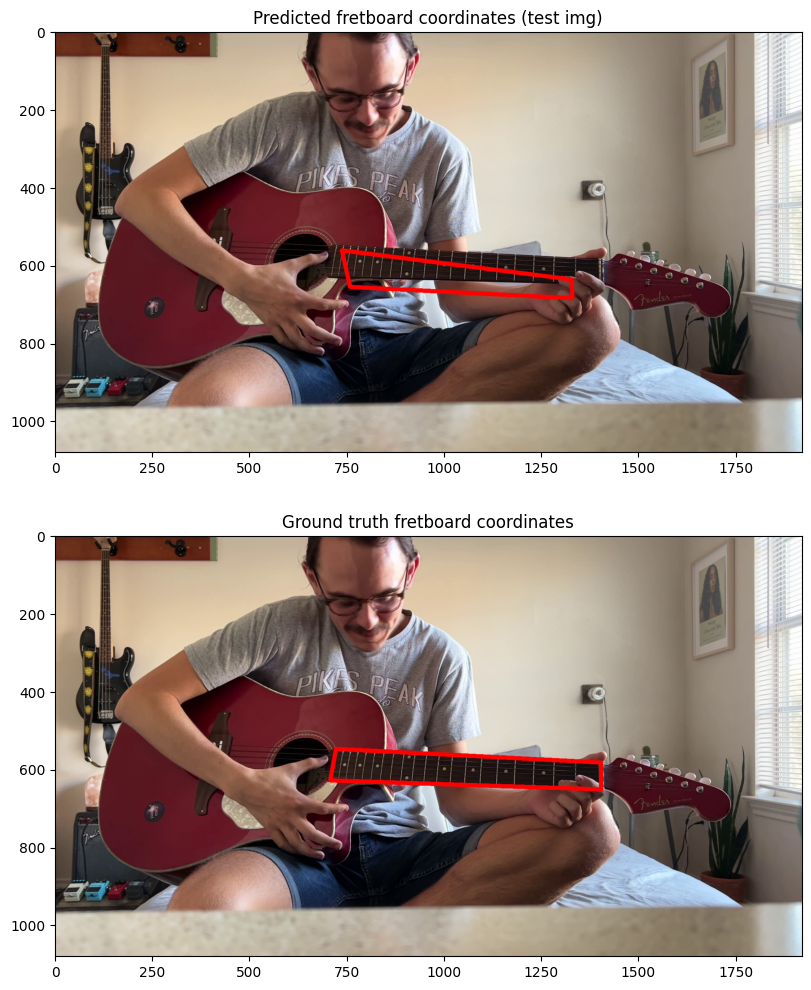

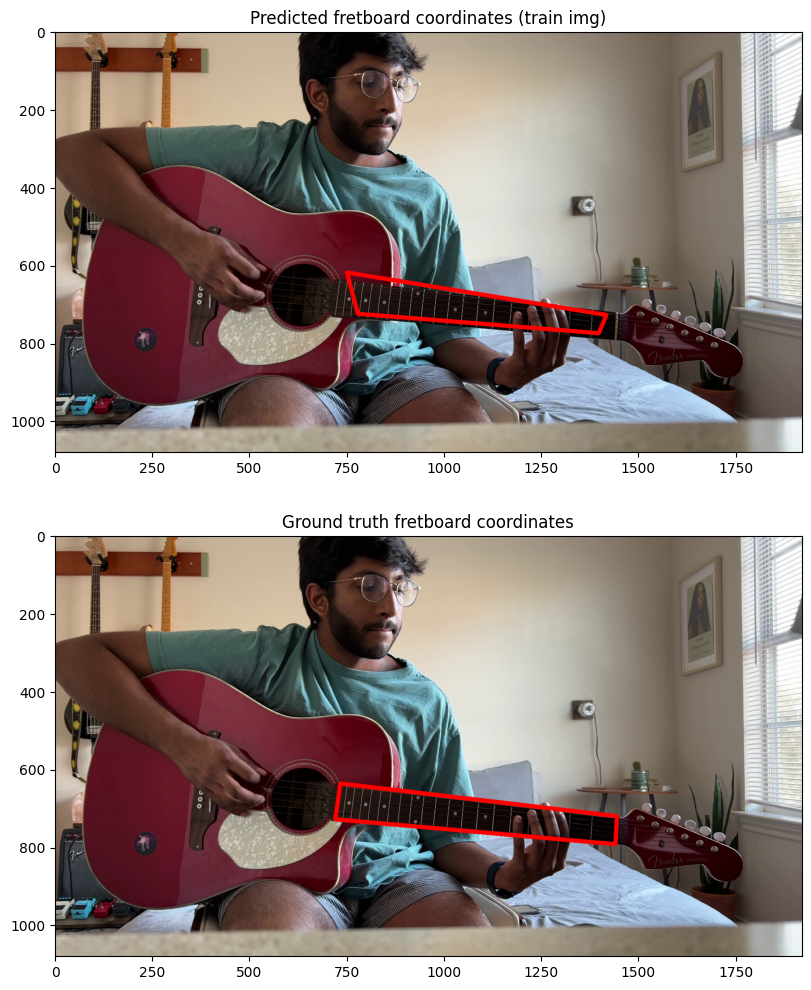

In [41]:
def pred_vs_gt_MLP(model, train_flag):
    with torch.inference_mode():
        if train_flag:
            file = random.choice(train_fns)
            x = train[file]
            x = torch.Tensor(x)
            y = load_label(file, True)
            img = cv.imread(os.path.join(train_path, file))
        else:
            file = random.choice(test_fns)
            x = test[file]
            x = torch.Tensor(x)
            y = load_label(file, False)
            img = cv.imread(os.path.join(test_path, file))

        pred = model(x)
        
        img2 = np.copy(img)
        pred_coords_vec = pred.detach().cpu().numpy()
        label_coords_vec = y.detach().cpu().numpy()
        
        unnormalize = np.array([1920, 1080])
        unnormalize = np.tile(unnormalize, 4)
        pred_coords_vec = pred_coords_vec * unnormalize
        label_coords_vec = label_coords_vec * unnormalize

        pred_coords = np.array([[pred_coords_vec[0], pred_coords_vec[1]], 
                                [pred_coords_vec[2], pred_coords_vec[3]],
                                [pred_coords_vec[4], pred_coords_vec[5]],
                                [pred_coords_vec[6], pred_coords_vec[7]]], np.int32)
        label_coords = np.array([[label_coords_vec[0], label_coords_vec[1]], 
                                [label_coords_vec[2], label_coords_vec[3]],
                                [label_coords_vec[4], label_coords_vec[5]],
                                [label_coords_vec[6], label_coords_vec[7]]], np.int32)
        
        pred_coords = pred_coords.reshape((-1,1,2))
        label_coords = label_coords.reshape((-1,1,2))
        
        cv.polylines(img, [pred_coords], True, (0,0,255), thickness=10)
        cv.polylines(img2, [label_coords], True, (0,0,255), thickness=10)

        plt.figure(figsize=(12,12))
        plt.subplot(2,1,1)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title("Predicted fretboard coordinates")
        plt.subplot(2,1,2)
        plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
        plt.title("Ground truth fretboard coordinates")
        plt.show()

def pred_vs_gt_CNN(model, dataset, train_flag):
    with torch.inference_mode():
        idx = random.choice(range(len(dataset)))
        x, y = dataset[idx][0], dataset[idx][1]
        x = x.unsqueeze(0)
        pred = model(x)
        fn = dataset.get_fn(idx)
        if train_flag:
            path = os.path.join(train_path, fn)
            train_str = "train"
        else:
            path = os.path.join(test_path, fn)
            train_str = "test"

        img1 = cv.imread(path)
        img2 = np.copy(img1)

        pred_coords_vec = pred.squeeze().detach().cpu().numpy()
        label_coords_vec = y.detach().cpu().numpy()

        unnormalize = np.array([1920, 1080])
        unnormalize = np.tile(unnormalize, 4)
        pred_coords_vec = pred_coords_vec * unnormalize
        label_coords_vec = label_coords_vec * unnormalize
        pred_coords = np.array([[pred_coords_vec[0], pred_coords_vec[1]], 
                                [pred_coords_vec[2], pred_coords_vec[3]],
                                [pred_coords_vec[4], pred_coords_vec[5]],
                                [pred_coords_vec[6], pred_coords_vec[7]]], np.int32)
        label_coords = np.array([[label_coords_vec[0], label_coords_vec[1]], 
                                [label_coords_vec[2], label_coords_vec[3]],
                                [label_coords_vec[4], label_coords_vec[5]],
                                [label_coords_vec[6], label_coords_vec[7]]], np.int32)
        
        pred_coords = pred_coords.reshape((-1,1,2))
        label_coords = label_coords.reshape((-1,1,2))
        
        cv.polylines(img1, [pred_coords], True, (0,0,255), thickness=10)
        cv.polylines(img2, [label_coords], True, (0,0,255), thickness=10)
        
        plt.figure(figsize=(12,12))
        plt.subplot(2,1,1)
        plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
        plt.title(f"Predicted fretboard coordinates ({train_str} img)")
        plt.subplot(2,1,2)
        plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
        plt.title(f"Ground truth fretboard coordinates")
        plt.show()

pred_vs_gt_CNN(cnn_1, test_dataset, False)
pred_vs_gt_CNN(cnn_1, train_dataset, True)
